# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [8]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST(root="data", train= False, download=True, transform=transform)


In [9]:
#DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**By combining these transformations into a Compose pipeline, we efficiently preprocess the input data, preparing it for training while also enhancing the training process by standardizing the input distribution. This preprocessing approach contributes to more stable and effective training of neural network models, ultimately leading to improved performance and generalization ability on unseen data.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [10]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [11]:
# Explore data
## YOUR CODE HERE ##
# Get the size of the training dataset
num_train_samples = len(train_data)
print("Number of training samples:", num_train_samples)

# Get the shape of the images in the dataset
image_shape = train_data[0][0].size()
print("Image shape:", image_shape)

# Get the number of classes in the dataset
num_classes = len(train_data.classes)
print("Number of classes:", num_classes)

Number of training samples: 60000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [12]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x
#initialize
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
#visualize
scripted = torch.jit.script(net)
torch.jit.save(scripted, "mnist_network.pt")

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
## YOUR CODE HERE ##
#loss function
criterion = nn.CrossEntropyLoss()

#specify optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [18]:
## YOUR CODE HERE ##
#Number of epochs to train
n_epochs = 10

# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(n_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 0.94% training loss: 0.18276
Epoch 1 validation accuracy: 0.96% validation loss: 0.13452
Epoch 2 training accuracy: 0.96% training loss: 0.13200
Epoch 2 validation accuracy: 0.96% validation loss: 0.14052
Epoch 3 training accuracy: 0.97% training loss: 0.10619
Epoch 3 validation accuracy: 0.96% validation loss: 0.11004
Epoch 4 training accuracy: 0.97% training loss: 0.09218
Epoch 4 validation accuracy: 0.97% validation loss: 0.11047
Epoch 5 training accuracy: 0.98% training loss: 0.07756
Epoch 5 validation accuracy: 0.97% validation loss: 0.10582
Epoch 6 training accuracy: 0.98% training loss: 0.07224
Epoch 6 validation accuracy: 0.97% validation loss: 0.10166
Epoch 7 training accuracy: 0.98% training loss: 0.06088
Epoch 7 validation accuracy: 0.97% validation loss: 0.08723
Epoch 8 training accuracy: 0.98% training loss: 0.05775
Epoch 8 validation accuracy: 0.97% validation loss: 0.09581
Epoch 9 training accuracy: 0.98% training loss: 0.05274
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

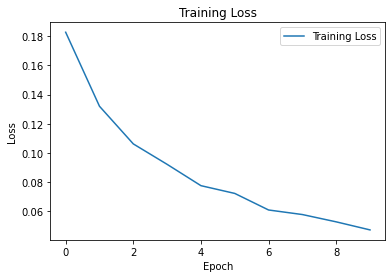

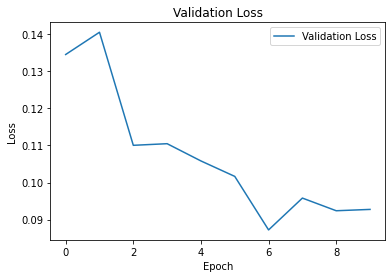

In [21]:
## YOUR CODE HERE ##
# Plotting training loss
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# validation loss is recorded
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:
## YOUR CODE HERE ##
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()

# Iterate over the test dataset
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    outputs = net(images)
    
    # Get predictions
    _, predicted = torch.max(outputs.data, 1)
    
    # Update total number of samples
    total += labels.size(0)
    
    # Update number of correct predictions
    correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = 100 * correct / total

print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 97.42%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
## YOUR CODE HERE ##
# Define the file path where you want to save the model
model_path = 'trained_model.pth'

# Save the model
torch.save(net.state_dict(), model_path)

print(f'Model saved to {model_path}')

Model saved to trained_model.pth
